# Aşama1

In [ ]:
# Gerekli kütüphanelerin yüklenmesi
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# BIST'teki bir hisse senedini seçelim (örneğin Garanti Bankası "GARAN.IS")
ticker = "GARAN.IS"
data = yf.download(ticker, start="2019-01-01", end="2024-12-16")


# Verinin ilk 5 satırını inceleyelim
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price      Adj Close    Close     High      Low     Open     Volume
Ticker      GARAN.IS GARAN.IS GARAN.IS GARAN.IS GARAN.IS   GARAN.IS
Date                                                               
2019-01-01  6.772315     7.95     7.95     7.95     7.95          0
2019-01-02  6.576386     7.72     7.97     7.69     7.93   66771138
2019-01-03  6.423051     7.54     7.81     7.52     7.68   75968527
2019-01-04  6.823427     8.01     8.02     7.61     7.61  110691734
2019-01-07  6.951207     8.16     8.28     8.08     8.09   89859815


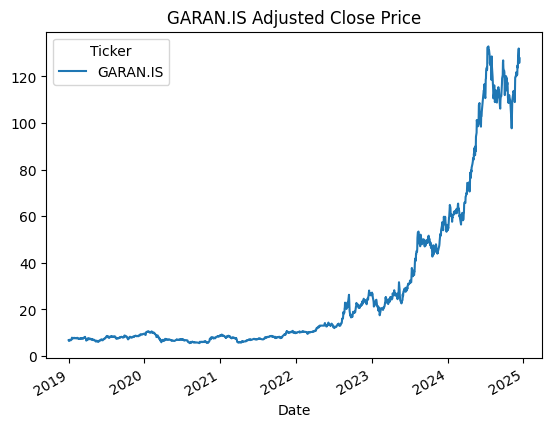

In [ ]:
# Zaman serisi olarak fiyat grafiği
data['Adj Close'].plot(title=f"{ticker} Adjusted Close Price")
plt.show()

In [ ]:
# Eksik verileri kontrol edelim
missing_values = data.isnull().sum()
print("Eksik değerler:\n", missing_values)

Eksik değerler:
 Price      Ticker  
Adj Close  GARAN.IS    0
Close      GARAN.IS    0
High       GARAN.IS    0
Low        GARAN.IS    0
Open       GARAN.IS    0
Volume     GARAN.IS    0
dtype: int64


In [ ]:
# Eksik değerleri dolduralım (örneğin ileri doldurma yöntemi - forward fill)
data.fillna(method='ffill', inplace=True)

# Aykırı değerlerin temizlenmesi (Z-score ile aykırı değerleri tespit edelim)
from scipy.stats import zscore
data['Z-Score'] = zscore(data['Adj Close'])
data = data[(data['Z-Score'] < 3) & (data['Z-Score'] > -3)]  # Z-Score -3 ile 3 aralığında olmayanları çıkar
data.drop(columns='Z-Score', inplace=True)

# Temizlenen veriyi inceleyelim
print(data.describe())

<ipython-input-5-f81c27e0bc88>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Price     Adj Close        Close         High          Low         Open  \
Ticker     GARAN.IS     GARAN.IS     GARAN.IS     GARAN.IS     GARAN.IS   
count   1487.000000  1487.000000  1487.000000  1487.000000  1487.000000   
mean      26.950181    28.443046    29.036779    27.929307    28.447317   
std       32.141546    31.885043    32.541748    31.267589    31.899236   
min        5.511557     6.470000     6.550000     6.240000     6.450000   
25%        7.598623     8.910000     9.055000     8.790000     8.900000   
50%       10.205325    11.780000    11.890000    11.660000    11.810000   
75%       28.068336    30.060000    30.940000    29.580000    30.120000   
max      126.900002   126.900002   130.899994   125.300003   129.000000   

Price         Volume  
Ticker      GARAN.IS  
count   1.487000e+03  
mean    1.107154e+08  
std     1.027223e+08  
min     0.000000e+00  
25%     3.891959e+07  
50%     8.421817e+07  
75%     1.472260e+08  
max     9.936633e+08  


<ipython-input-5-f81c27e0bc88>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns='Z-Score', inplace=True)


# Aşama2

bu aşamada LSTM modelini kullanarak gelecekteki fiyatları tahmin edeceğiz.

In [ ]:
!pip install scikit-learn
!pip install tensorflow

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Verinin Hazırlanması



Öncelikle, veriyi model için uygun hale getirmemiz gerekiyor. Zaman serisi verilerini kullanırken geçmiş verilere göre tahmin yapmak istediğimiz için, veriyi eğitim ve test setlerine ayıracağız.

In [ ]:
# Sadece kapanış fiyatlarını alalım
data = data[['Adj Close']]

In [ ]:
# Veriyi MinMaxScaler ile ölçekleyelim (0-1 aralığına)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Eğitim ve test setlerine ayıralım (%80 eğitim, %20 test)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:]

In [ ]:
# Zaman serisi için X ve y veri setlerini oluşturalım
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
# Eğitim verisi
time_step = 60  # 60 gün geçmişi kullanarak tahmin yapacağız
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Veriyi LSTM için 3D hale getirelim (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# LSTM Modelinin Oluşturulması ve Eğitilmesi

LSTM modeli zaman serisi verilerini öğrenmede oldukça başarılıdır. Şimdi modeli oluşturup eğiteceğiz.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# LSTM modeli oluşturalım
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Modeli derleyelim
model.compile(optimizer='adam', loss='mean_squared_error')

# Modeli eğitelim
model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - loss: 0.0076 - val_loss: 0.0082
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 4.7106e-04 - val_loss: 0.0021
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.7434e-04 - val_loss: 0.0071
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 2.1691e-04 - val_loss: 0.0023
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 2.2070e-04 - val_loss: 0.0018
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 2.1753e-04 - val_loss: 0.0019
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.8725e-04 - val_loss: 0.0017
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 1.9188e-04 - val_loss: 0.0017
Epoch 9/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 1.9069e-04 - val_loss: 0.0037
Epoch 10/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 1.7582e-04 - val_loss: 0.0029
Epoch 11/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.7643e-04 - val_loss: 0.0016
Epoch 12/20
18/18 ━━━

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 1.3784e-04 - val_loss: 0.0014
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 1.2440e-04 - val_loss: 0.0012
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 1.8606e-04 - val_loss: 0.0013
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7498e-04 - val_loss: 0.0012
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 1.5285e-04 - val_loss: 0.0014
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 1.4272e-04 - val_loss: 0.0012
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 2.0602e-04 - val_loss: 0.0014
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 1.4008e-04 - val_loss: 0.0066
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 1.5263e-04 - val_loss: 0.0015
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 1.2729e-04 - val_loss: 0.0043


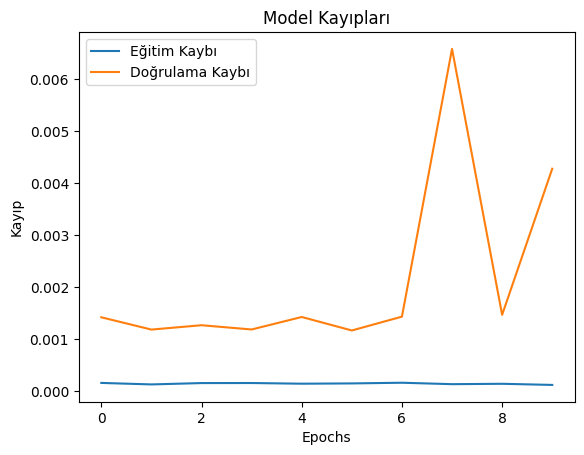

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

# Eğitim ve doğrulama kayıplarını görselleştirelim
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title("Model Kayıpları")
plt.xlabel("Epochs")
plt.ylabel("Kayıp")
plt.legend()
plt.show()

In [ ]:
model.save('lstm_model.h5')
print("Model başarıyla kaydedildi!")

Model başarıyla kaydedildi!


# Modelin Test Edilmesi ve Sonuçların Görselleştirilmesi

Model eğitildikten sonra test seti üzerinde tahmin yapıp sonuçları görselleştireceğiz.

In [ ]:
print("Data Index Shape:", len(data.index))
print("Scaled Data Shape:", scaled_data.shape)

Data Index Shape: 1487
Scaled Data Shape: (1487, 1)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Train Predictions Shape: (1128, 1)
Test Predictions Shape: (237, 1)
Train Index Shape: 1128
Test Index Shape: 237


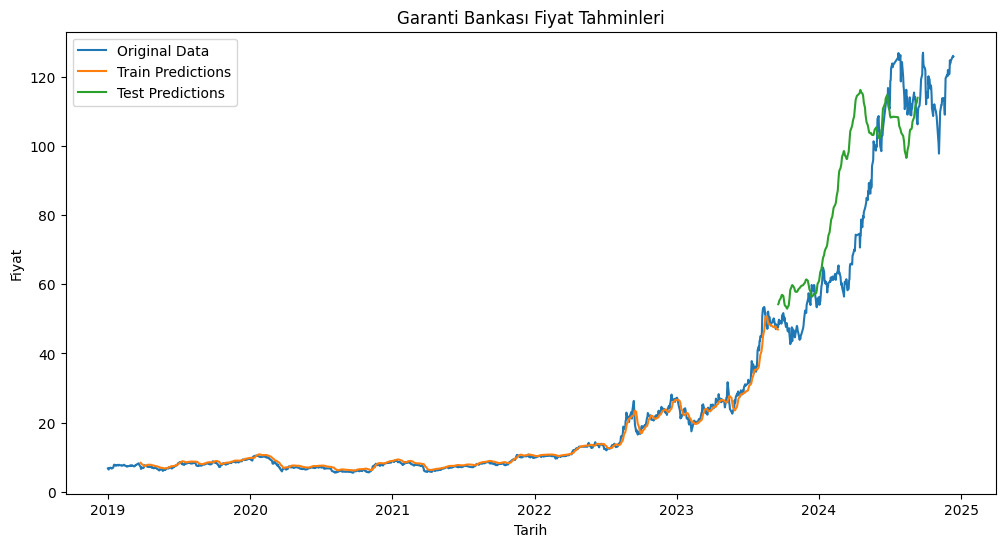

In [ ]:
# Model tahminleri
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Veriyi orijinal ölçeğine geri döndürelim
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Tahmin edilen değerlerin boyutlarını yeniden ayarlayalım
train_predict = train_predict[:len(X_train)]
test_predict = test_predict[:len(X_test)]

# Eğitim ve test seti için tarih dizilerini oluşturma
train_index = data.index[time_step:time_step + len(train_predict)]
test_index = data.index[time_step + len(train_predict):time_step + len(train_predict) + len(test_predict)]

# Boyutları kontrol edelim
print("Train Predictions Shape:", train_predict.shape)
print("Test Predictions Shape:", test_predict.shape)
print("Train Index Shape:", len(train_index))
print("Test Index Shape:", len(test_index))

# scaled_data boyutuyla uyumlu tarih dizisi
adjusted_index = data.index[-scaled_data.shape[0]:]

# Sonuçları görselleştirelim
plt.figure(figsize=(12, 6))
plt.plot(adjusted_index, scaler.inverse_transform(scaled_data), label='Original Data')  # Yeni tarih dizisi
plt.plot(train_index, train_predict, label='Train Predictions')
plt.plot(test_index, test_predict, label='Test Predictions')
plt.title("Garanti Bankası Fiyat Tahminleri")
plt.xlabel("Tarih")
plt.ylabel("Fiyat")
plt.legend()
plt.show()



Bir sonraki işlem günü fiyat tahmini

In [ ]:
print(data.columns)

MultiIndex([('Adj Close', 'GARAN.IS')],
           names=['Price', 'Ticker'])


In [ ]:
print(data.head())

Price      Adj Close
Ticker      GARAN.IS
Date                
2019-01-01  6.772315
2019-01-02  6.576386
2019-01-03  6.423051
2019-01-04  6.823427
2019-01-07  6.951207


In [ ]:
# Bir sonraki işlem gününün tahmini için verinin son 60 gününü alalım
last_60_days = data['Adj Close'][-60:].values  # Son 60 gün kapanış fiyatlarını al
last_60_days_scaled = scaler.transform(last_60_days.reshape(-1, 1))  # Veriyi ölçekle

# Modelin tahmini yapması için uygun şekli verelim (1, time_steps, features)
X_test_new = np.reshape(last_60_days_scaled, (1, last_60_days_scaled.shape[0], 1))

# Bir sonraki işlem gününün tahminini yapalım
next_day_pred = model.predict(X_test_new)
next_day_pred = scaler.inverse_transform(next_day_pred)  # Tahmini orijinal ölçeğe döndürelim

# Tahmini gösterelim
print("Bir sonraki işlem gününün tahmini fiyatı:", next_day_pred[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Bir sonraki işlem gününün tahmini fiyatı: 115.162506


# Sonuç

Bu aşamada, LSTM modeli kullanılarak Garanti Bankası hisse senedi fiyatları üzerinde tahmin yapıldı. Tahmin sonuçları grafik üzerinde gösterildi. Model, 60 gün geçmiş veriyi kullanarak gelecekteki fiyatları tahmin etti.

# 3.Aşama Risk Yönetimi

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scipy


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Risk yönetimi hesaplamaları için daha önce hazırladığımız data DataFrame'ini kullanacağız. Özellikle kapanış fiyatlarına ihtiyacımız var.

In [ ]:
# Hisse senedi verilerini çekelim (örnek olarak GARAN.IS)
ticker = "GARAN.IS"
data = yf.download(ticker, start="2010-01-01", end="2024-12-16")
data = data[['Adj Close']]
data['Returns'] = data['Adj Close'].pct_change()  # Getirileri hesaplayalım
data.dropna(inplace=True)  # NaN değerleri kaldır

[*********************100%***********************]  1 of 1 completed


Volatilite Hesaplama

Volatilite, genellikle standart sapma ile hesaplanır:

In [ ]:
# Volatilite hesaplama
volatility = data['Returns'].std() * np.sqrt(252)  # Yıllıklaştırma
print("Yıllık Volatilite:", volatility)

Yıllık Volatilite: 0.38616118508945474


Value at Risk (VaR) Hesaplama

VaR, genellikle normal dağılım varsayımı altında hesaplanır. Örneğin, %95 güven düzeyinde VaR hesaplayabiliriz:

In [ ]:
# Value at Risk hesaplama
confidence_level = 0.95
VaR = np.percentile(data['Returns'], (1 - confidence_level) * 100)
print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {VaR:.2%}")


Value at Risk (VaR) at 95.0% confidence level: -3.49%


Sharpe Oranı Hesaplama

Sharpe oranı, getiri ve volatiliteyi kullanarak hesaplanır:

In [ ]:
# Sharpe Oranı hesaplama
risk_free_rate = 0.05  # Örnek olarak %5'lik bir risksiz getiri
mean_return = data['Returns'].mean() * 252  # Yıllık getiri
sharpe_ratio = (mean_return - risk_free_rate) / volatility
print("Sharpe Oranı:", sharpe_ratio)


Sharpe Oranı: 0.6311974471848182


Sonuçların Görselleştirilmesi

Sonuçları görselleştirmek için, getiri dağılımını çizebiliriz:

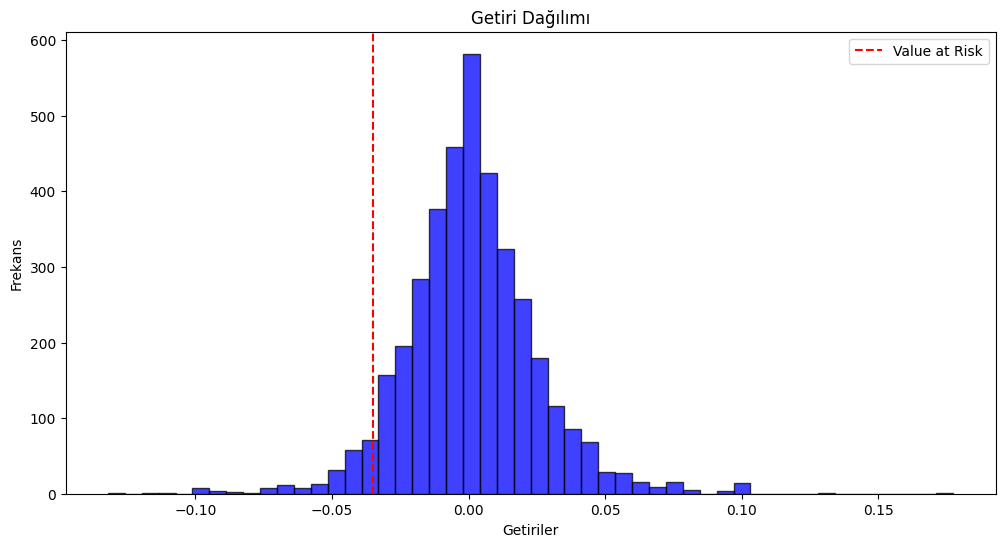

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(data['Returns'], bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title('Getiri Dağılımı')
plt.xlabel('Getiriler')
plt.ylabel('Frekans')
plt.axvline(x=VaR, color='red', linestyle='--', label='Value at Risk')
plt.legend()
plt.show()


# Aşama 4

# Portföy Optimizasyonu

Portföy optimizasyonunun amacı, belirli bir risk seviyesinde en yüksek getiriyi sağlayacak portföyü oluşturmaktır. Bunu yaparken çeşitli hisse senetleri arasındaki korelasyonlar ve volatilite dikkate alınır.Bu aşamada, çeşitli hisse senetlerinden oluşan bir portföyde, Sharpe Oranı’nı maksimize ederek en iyi bileşimi bulacağız.

Örnek olarak, Borsa İstanbul’daki bazı hisse senetlerinden oluşan bir portföy belirleyelim. Bu portföyde yer alan hisse senetlerinin günlük getiri ve kovaryans matrisini hesaplayacağız.

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

# Örnek portföy hisse senetleri (Garanti Bankası, Akbank, Turkcell, THY)
tickers = ['GARAN.IS', 'AKBNK.IS', 'TCELL.IS', 'THYAO.IS']
data = yf.download(tickers, start="2018-01-01", end="2024-12-16")['Adj Close']

# Günlük getirileri hesaplayalım
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 252  # Yıllık getiriler
cov_matrix = returns.cov() * 252  # Yıllık kovaryans matrisi

[*********************100%***********************]  4 of 4 completed


Rastgele Portföy Simülasyonu : Portföy optimizasyonunu gerçekleştirmek için çok sayıda rastgele portföy oluşturup, her birinin getiri, risk ve Sharpe oranını hesaplayacağız. En yüksek Sharpe oranına sahip portföy, en iyi portföy olarak seçilecek.

In [ ]:
# Simülasyon parametreleri
num_portfolios = 10000
results = np.zeros((3, num_portfolios))  # [Return, Volatility, Sharpe Ratio]

# Rastgele portföyler oluştur ve performanslarını hesapla
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)  # Ağırlıkları normalize et

    # Portföy performansını hesapla
    port_return = np.dot(weights, mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - 0.05) / port_volatility  # Risksiz getiri oranı %5

    # Sonuçları kaydet
    results[0, i] = port_return
    results[1, i] = port_volatility
    results[2, i] = sharpe_ratio

En İyi Portföyü Seçme : En yüksek Sharpe oranına sahip portföyü bulalım.

In [ ]:
# En yüksek Sharpe oranına sahip portföyü bul
max_sharpe_idx = np.argmax(results[2])
optimal_return = results[0, max_sharpe_idx]
optimal_volatility = results[1, max_sharpe_idx]
optimal_sharpe_ratio = results[2, max_sharpe_idx]

print(f"En iyi portföyün getirisi: {optimal_return:.2f}")
print(f"En iyi portföyün volatilitesi: {optimal_volatility:.2f}")
print(f"En iyi portföyün Sharpe Oranı: {optimal_sharpe_ratio:.2f}")

En iyi portföyün getirisi: 0.47
En iyi portföyün volatilitesi: 0.34
En iyi portföyün Sharpe Oranı: 1.24


Optimum Portföyün Ağırlıkları : En iyi portföydeki her bir hisse senedinin ağırlıklarını gösterelim.

In [ ]:
optimal_weights = np.random.random(len(tickers))
optimal_weights /= np.sum(optimal_weights)  # Normalize et
print("En iyi portföydeki ağırlıklar:", dict(zip(tickers, optimal_weights)))

En iyi portföydeki ağırlıklar: {'GARAN.IS': 0.12319278495527397, 'AKBNK.IS': 0.20498624844066374, 'TCELL.IS': 0.18894529957368003, 'THYAO.IS': 0.48287566703038237}


Optimum Portföyü Görselleştirme : Tüm portföyleri bir grafik üzerinde görselleştirip en iyi portföyü işaretleyelim.

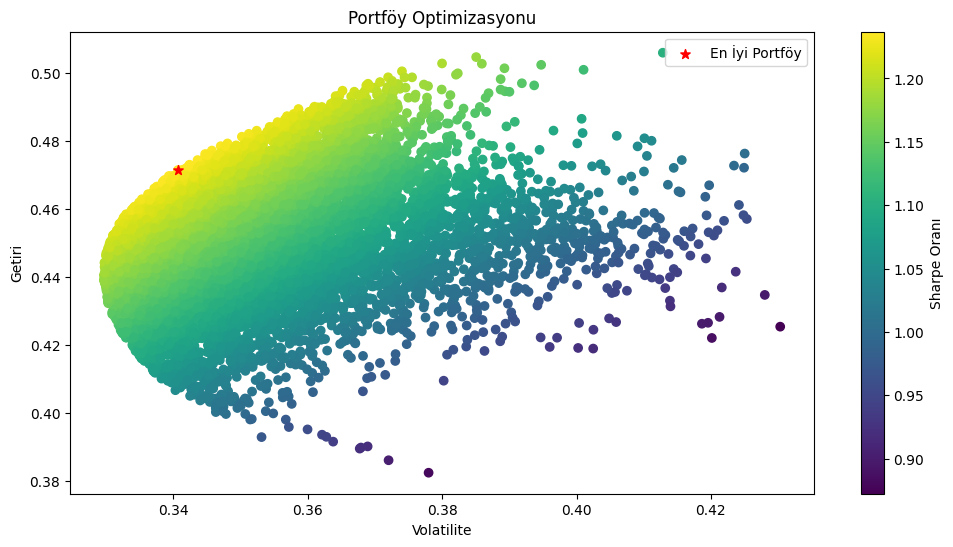

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis')
plt.colorbar(label="Sharpe Oranı")
plt.scatter(optimal_volatility, optimal_return, color='red', s=50, marker='*', label='En İyi Portföy')
plt.xlabel("Volatilite")
plt.ylabel("Getiri")
plt.title("Portföy Optimizasyonu")
plt.legend()
plt.show()

# Sonuç

En iyi portföy, seçilen hisse senetlerinin optimize edilmiş ağırlıklarına sahip olup, en yüksek Sharpe oranına göre en iyi risk-getiri dengesini sunmaktadır.

Bu sonuçlar, yatırımcının riski minimize ederek en yüksek getiriyi hedeflemesine olanak tanır.

# Aşama 5

Tahmin Modelleri: Daha önce eğittiğimiz LSTM modelini kullanarak gelecekteki fiyatları tahmin edeceğiz.

Dash veya Streamlit: Kullanıcı dostu bir arayüz geliştirmek için.

In [ ]:
!pip install dash streamlit yfinance tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3


Canlı Veri Çekme ve Tahmin Yapma

In [ ]:
import yfinance as yf
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Eğitilmiş modeli yükleyelim
model = load_model('lstm_model.h5')  # Model dosyasını doğru yolda bulundur

# Örnek hisse senedi (GARAN.IS)
ticker = "GARAN.IS"

# Canlı veri çekme
data = yf.download(ticker, period="1mo", interval="1d")  # Son 30 günlük veri
last_60_days = data['Adj Close'].values  # Son 60 gün kapanış fiyatları

# Veriyi ölçekleme
scaler = MinMaxScaler(feature_range=(0, 1))
last_60_days_scaled = scaler.fit_transform(last_60_days.reshape(-1, 1))

# Modelin tahmini için veriyi yeniden şekillendirme
X_test_new = np.reshape(last_60_days_scaled, (1, last_60_days_scaled.shape[0], 1))

# Bir sonraki işlem gününün tahminini yapalım
next_day_pred = model.predict(X_test_new)
next_day_pred = scaler.inverse_transform(next_day_pred)  # Ters ölçekleme

# Tahmini gösterelim
print(f"{ticker} için bir sonraki işlem gününün tahmini fiyatı: {next_day_pred[0][0]:.2f} TL")

[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
GARAN.IS için bir sonraki işlem gününün tahmini fiyatı: 127.00 TL


# Kullanıcı Arayüzü

Colab'ın Kendi arayüzünü kullanıyoruz(IPython Widgets)

In [ ]:
from IPython.display import display
import ipywidgets as widgets

In [ ]:
#st.title("Hisse Senedi Tahmin Sistemi")
#st.write("Bir sonraki işlem gününün fiyat tahminini görün.")

ticker_input = widgets.Text(
    value='GARAN.IS',
    placeholder='Hisse senedi sembolünü girin',
    description='Ticker:',
    disabled=False
)

button = widgets.Button(description="Tahmin Yap")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        output.clear_output()
        print(f"Tahmin edilen fiyat: {next_day_pred[0][0]:.2f} TL")

button.on_click(on_button_clicked)
display(ticker_input, button, output)

Text(value='GARAN.IS', description='Ticker:', placeholder='Hisse senedi sembolünü girin')

Button(description='Tahmin Yap', style=ButtonStyle())

Output()